# Benchmark ElasticNet/Lasso For Solvers CD

In [1]:
import gc
from time import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet

matplotlib.pyplot.ion()

alpha = 0.1
l1_ratio = 0.5
tol = 1e-4  # default is 1e-4
seed = 1234


def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


def bench(alpha, l1_ratio, solver, X, Y, X_test, Y_test, ref_coef):
    """Benchmark Cython CD gram solver.
    Therefore, this benchmark expects with `fit_intercept=False`.
    """
    gc.collect()

    # start time
    tstart = time()
    clf = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        precompute=True,  # enet_coordinate_descent_gram
        fit_intercept=False,  # reduced overhead
        tol=tol,
    ).fit(X, Y)
    delta = time() - tstart
    # stop time
    obj = (
        0.5 * np.mean((Y - clf.predict(X)) ** 2)
        + alpha * l1_ratio * np.sum(np.abs(clf.coef_))
        + 0.5 * alpha * (1 - l1_ratio) * np.sum(clf.coef_**2)
    )
    coef_mean_abs_diff = np.abs(ref_coef - clf.coef_.ravel()).mean()

    print(" duration: %0.3fs" % delta)
    print(" objectiv: %f" % obj)
    print(" mean abs diff of coef: %f" % coef_mean_abs_diff)
    print(" rmse test set: %f" % rmse(Y_test, clf.predict(X_test)))

    return [delta, obj, coef_mean_abs_diff]

## Profiling - where is the bottleneck?
Bottleneck is in preprocessing:
- centering `X` and `y` (only with `fit_intercept=True`)
- copying `X`

In [3]:
X, y = make_regression(
    n_samples=50_000, n_features=1000, noise=0.1, n_informative=100, random_state=seed
)
X = np.asfortranarray(X)
%time ElasticNet(alpha=0.19, l1_ratio=l1_ratio, precompute=True, verbose=1).fit(X, y);

  Time in fit validation = 0.26387786865234375 s
  Time in fit _pre_fit = 0.5280959606170654 s
Time in fit preprocessing = 0.7926478385925293 s
  Init time = 0.000631
  Time feature loop = 0.00221 s
  Time convergence = 6e-06 s
  Number of convergence checks = 1 in 5 iterations
Time in fit path function = 0.0032510757446289062 s
Time in fit postprocessing = 0.00015115737915039062 s
CPU times: user 3 s, sys: 153 ms, total: 3.15 s
Wall time: 830 ms


.

In [4]:
%time ElasticNet(alpha=0.19, l1_ratio=l1_ratio, precompute=False, verbose=1).fit(X, y);

  Time in fit validation = 0.2920999526977539 s
  Time in fit _pre_fit = 0.08787274360656738 s
Time in fit preprocessing = 0.3801398277282715 s
  Init time = 0.06857699999999989
  Time feature loop = 0.306567 s
  Time convergence = 0.019407 s
    Number of convergence checks = 1 in 5 iterations
Time in fit path function = 0.39502692222595215 s
Time in fit postprocessing = 0.00015878677368164062 s
CPU times: user 854 ms, sys: 153 ms, total: 1.01 s
Wall time: 807 ms


.

In [5]:
from sklearn.linear_model import ElasticNetCV

X, y = make_regression(
    n_samples=10_000, n_features=1000, noise=0.1, n_informative=100, random_state=seed
)
m = ElasticNetCV(l1_ratio=l1_ratio).fit(X, y)
print(f"Optimal alpha={m.alpha_}")
print(f"{np.sum(m.coef_ == 0)} out of {m.coef_.shape[0]} coefficients are zero")

Optimal alpha=0.19261699636519697
127 out of 1000 coefficients are zero


In [6]:
m = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X, y)
print(f"alpha={alpha}")
print(f"{np.sum(m.coef_ == 0)} out of {m.coef_.shape[0]} coefficients are zero")

alpha=0.1
121 out of 1000 coefficients are zero


In [7]:
%time np.copy(X);

CPU times: user 14.8 ms, sys: 1.92 ms, total: 16.7 ms
Wall time: 15.2 ms


In [8]:
%time np.dot(X.T, X);

CPU times: user 524 ms, sys: 9.53 ms, total: 534 ms
Wall time: 125 ms


In [9]:
%time np.mean(X, axis=0);

CPU times: user 7.65 ms, sys: 1.52 ms, total: 9.17 ms
Wall time: 7.73 ms


In [10]:
%time X - np.mean(X, axis=0);

CPU times: user 25.2 ms, sys: 2.22 ms, total: 27.4 ms
Wall time: 28.4 ms


## Increase samples, fix features

### Max samples = 200,000, features=1000

In [2]:
cd_results = []
tol = 1e-4
n = 10
step = 20_000
n_features = 1000
n_informative = n_features // 10
n_test_samples = 1000
for i in range(1, n + 1):
    print("====================================================================")
    print(
        "Iter {} of {}, features={}, samples={}, test samples={}".format(
            i, n, n_features, (i * step), n_test_samples
        )
    )
    print("====================================================================")

    X, Y, coef_ = make_regression(
        n_samples=(i * step) + n_test_samples,
        n_features=n_features,
        noise=0.1,
        n_informative=n_informative,
        coef=True,
        random_state=seed,
    )
    X -= X.mean(axis=0)
    Y -= Y.mean(axis=0)

    X_test = X[-n_test_samples:]
    Y_test = Y[-n_test_samples:]
    X = X[: (i * step)]
    Y = Y[: (i * step)]

    print("benchmarking coordinate descent: ")
    cd_results.append(bench(alpha, l1_ratio, "cd", X, Y, X_test, Y_test, coef_))
    del X, Y, X_test, Y_test

cd_results = np.array(cd_results)

Iter 1 of 10, features=1000, samples=20000, test samples=1000
benchmarking coordinate descent: 
 duration: 0.485s
 objectiv: 7576.707728
 mean abs diff of coef: 0.342140
 rmse test set: 27.950378
Iter 2 of 10, features=1000, samples=40000, test samples=1000
benchmarking coordinate descent: 
 duration: 1.068s
 objectiv: 7534.038362
 mean abs diff of coef: 0.289434
 rmse test set: 27.533570
Iter 3 of 10, features=1000, samples=60000, test samples=1000
benchmarking coordinate descent: 
 duration: 1.754s
 objectiv: 8857.678848
 mean abs diff of coef: 0.301504
 rmse test set: 28.767285
Iter 4 of 10, features=1000, samples=80000, test samples=1000
benchmarking coordinate descent: 
 duration: 2.413s
 objectiv: 7016.196688
 mean abs diff of coef: 0.257808
 rmse test set: 25.242455
Iter 5 of 10, features=1000, samples=100000, test samples=1000
benchmarking coordinate descent: 
 duration: 3.201s
 objectiv: 8436.524745
 mean abs diff of coef: 0.273778
 rmse test set: 28.729163
Iter 6 of 10, featu

In [15]:
# RESULTS MAIN
# time, objective, mean(abs(coef_diff))
cd_results

array([[5.04482031e-01, 7.57670773e+03, 3.42140309e-01],
       [1.10022402e+00, 7.53403836e+03, 2.89433791e-01],
       [1.97008801e+00, 8.85767885e+03, 3.01503615e-01],
       [2.41216612e+00, 7.01619669e+03, 2.57807888e-01],
       [3.49784660e+00, 8.43652475e+03, 2.73777630e-01],
       [4.55174208e+00, 7.12579667e+03, 2.45977591e-01],
       [5.29429817e+00, 7.68852160e+03, 2.50490130e-01],
       [6.42195415e+00, 8.91115432e+03, 2.75837493e-01],
       [6.97268987e+00, 8.79644301e+03, 2.72195146e-01],
       [9.40416098e+00, 8.65606151e+03, 2.61646490e-01]])

In [3]:
# RESULTS PR
cd_results

array([[4.85033989e-01, 7.57670773e+03, 3.42140309e-01],
       [1.06766486e+00, 7.53403836e+03, 2.89433791e-01],
       [1.75434995e+00, 8.85767885e+03, 3.01503615e-01],
       [2.41252184e+00, 7.01619669e+03, 2.57807888e-01],
       [3.20060396e+00, 8.43652475e+03, 2.73777630e-01],
       [4.12740493e+00, 7.12579667e+03, 2.45977591e-01],
       [5.13423800e+00, 7.68852160e+03, 2.50490130e-01],
       [6.07307792e+00, 8.91115432e+03, 2.75837493e-01],
       [7.16410398e+00, 8.79644301e+03, 2.72195146e-01],
       [7.82733417e+00, 8.65606151e+03, 2.61646490e-01]])

In [4]:
cd_results_main = np.array(
    [
        [5.04482031e-01, 7.57670773e03, 3.42140309e-01],
        [1.10022402e00, 7.53403836e03, 2.89433791e-01],
        [1.97008801e00, 8.85767885e03, 3.01503615e-01],
        [2.41216612e00, 7.01619669e03, 2.57807888e-01],
        [3.49784660e00, 8.43652475e03, 2.73777630e-01],
        [4.55174208e00, 7.12579667e03, 2.45977591e-01],
        [5.29429817e00, 7.68852160e03, 2.50490130e-01],
        [6.42195415e00, 8.91115432e03, 2.75837493e-01],
        [6.97268987e00, 8.79644301e03, 2.72195146e-01],
        [9.40416098e00, 8.65606151e03, 2.61646490e-01],
    ]
)
cd_results_pr = np.array(
    [
        [4.85033989e-01, 7.57670773e03, 3.42140309e-01],
        [1.06766486e00, 7.53403836e03, 2.89433791e-01],
        [1.75434995e00, 8.85767885e03, 3.01503615e-01],
        [2.41252184e00, 7.01619669e03, 2.57807888e-01],
        [3.20060396e00, 8.43652475e03, 2.73777630e-01],
        [4.12740493e00, 7.12579667e03, 2.45977591e-01],
        [5.13423800e00, 7.68852160e03, 2.50490130e-01],
        [6.07307792e00, 8.91115432e03, 2.75837493e-01],
        [7.16410398e00, 8.79644301e03, 2.72195146e-01],
        [7.82733417e00, 8.65606151e03, 2.61646490e-01],
    ]
)

Text(0, 0.5, 'training time (s)')

<Figure size 640x480 with 0 Axes>

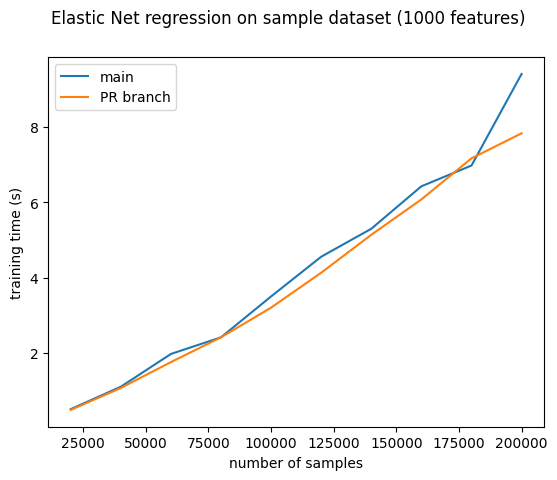

In [5]:
plt.clf()
fig, ax = plt.subplots()
xx = np.arange(step, n * step + 1, step)
fig.suptitle("Elastic Net regression on sample dataset (%d features)" % n_features)
ax.plot(xx, cd_results_main[:, 0], label="main")
ax.plot(xx, cd_results_pr[:, 0], label="PR branch")
ax.legend()
ax.set_xlabel("number of samples")
ax.set_ylabel("training time (s)")

In [7]:
X, y = make_regression(
    n_samples=10_000, n_features=1000, noise=0.1, n_informative=1000, random_state=123
)

In [8]:
# main
%time LassoCV(precompute=True).fit(X, y)

CPU times: user 4.59 s, sys: 227 ms, total: 4.82 s
Wall time: 2.41 s


,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,True
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,None
,verbose,False
,n_jobs,None


In [10]:
# PR
%time LassoCV(precompute=True).fit(X, y)

CPU times: user 5.16 s, sys: 262 ms, total: 5.42 s
Wall time: 2.63 s


,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,True
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,None
,verbose,False
,n_jobs,None
